In [148]:
## Packages
# system
import os
import math
# data wrangling
import numpy as np
import pandas as pd
from scipy import stats
from dfply import *
import statistics
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
# models
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, StratifiedKFold, cross_val_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, recall_score, make_scorer, accuracy_score, balanced_accuracy_score, f1_score, precision_score, roc_auc_score
from sklearn.preprocessing import normalize, StandardScaler
## Settings
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
pd.set_option('display.width', 1000)

## Data Import

In [149]:
df = pd.read_csv('../processed_data/provider_final_new.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df = df.set_index('Provider')
display(df.shape)
df.head(3)

(5410, 46)

,PotentialFraud,DurationMedianIP,DurationMeanIP,DurationMedianOP,DurationMeanOP,Serves,ChronCondsMedian,ChronCondsMean,ChronConsMode,PtAgeMedian,PtAgeMean,NumPtsIP,NumPtsOP,NumStatesIP,NumStatesOP,SharePhysician,MergeAvgClaimReimbursed,NumTopCodeClaim,DupClaimNum_IP,DupClaimRatio_IP,DupClaim_IP,DupClaimStatesNum_IP,DupClaimMultiState_IP,DupClaimProviderNum_IP,DupClaimMultiProvider_IP,DupClaimStartDtNum_IP,DupClaimMultiStartDt_IP,DupClaimNum_OP,DupClaimRatio_OP,DupClaim_OP,DupClaimStatesNum_OP,DupClaimMultiState_OP,DupClaimProviderNum_OP,DupClaimMultiProvider_OP,DupClaimStartDtNum_OP,DupClaimMultiStartDt_OP,AvgDuration,NumOfPt,NumOfClm,ClmPerPt,TotalRev,RevPerPt,ClmNoPhy,ClmAllPhy,ClmNoProc,ClmPerDt
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV51001,No,4.0,5.00000,0.0,0.550000,Both,6.0,5.760000,5.0,79.0,77.880000,5.0,19.0,1.0,1.0,1.0,4185.600000,5.0,0.0,0.000000,no,0.0,no,0.0,no,0.0,no,11.0,0.550000,yes,50.0,yes,422.0,yes,278.0,yes,1.44,24,25,1.04,109980,4582.50,0,2,23,1.09
PRV51003,Yes,4.0,5.16129,0.0,2.357143,Both,7.0,6.674242,6.0,71.0,69.083333,53.0,66.0,3.0,3.0,1.0,4588.409091,25.0,1.0,0.016129,yes,2.0,yes,2.0,yes,2.0,yes,25.0,0.357143,yes,52.0,yes,1351.0,yes,372.0,yes,3.67,117,132,1.13,671956,5743.21,0,4,93,1.19
PRV51004,No,0.0,0.00000,0.0,1.429530,OP,7.0,6.812081,8.0,72.0,71.261745,0.0,138.0,0.0,9.0,1.0,350.134228,5.0,0.0,0.000000,no,0.0,no,0.0,no,0.0,no,72.0,0.483221,yes,52.0,yes,3006.0,yes,375.0,yes,1.43,138,149,1.08,52480,380.29,0,12,149,1.27


## dummy variables

In [150]:
# Make dummies
encode_cols = df[~df.applymap(np.isreal)].dropna(axis=1).columns.to_list()
print(encode_cols)
df[encode_cols[2:]] = df[encode_cols[2:]].applymap(lambda x: 1 if x.lower() == 'yes' else 0)
dummies = pd.get_dummies(df['Serves'],prefix='Serves_',drop_first=True)
df_dum = pd.concat([df.drop('Serves',axis=1),dummies],axis=1)
df_dum.shape

['PotentialFraud', 'Serves', 'DupClaim_IP', 'DupClaimMultiState_IP', 'DupClaimMultiProvider_IP', 'DupClaimMultiStartDt_IP', 'DupClaim_OP', 'DupClaimMultiState_OP', 'DupClaimMultiProvider_OP', 'DupClaimMultiStartDt_OP']


(5410, 47)

#### convert potential fraud flag to 1 & 0

In [151]:
# this is for pos_label for precision & recall for gridsearchcv
df_dum['PotentialFraud'] = np.where(df_dum['PotentialFraud']=='Yes', 1, 0)

In [152]:
display(df_dum.shape)
display(df_dum.sample(3))

(5410, 47)

,PotentialFraud,DurationMedianIP,DurationMeanIP,DurationMedianOP,DurationMeanOP,ChronCondsMedian,ChronCondsMean,ChronConsMode,PtAgeMedian,PtAgeMean,NumPtsIP,NumPtsOP,NumStatesIP,NumStatesOP,SharePhysician,MergeAvgClaimReimbursed,NumTopCodeClaim,DupClaimNum_IP,DupClaimRatio_IP,DupClaim_IP,DupClaimStatesNum_IP,DupClaimMultiState_IP,DupClaimProviderNum_IP,DupClaimMultiProvider_IP,DupClaimStartDtNum_IP,DupClaimMultiStartDt_IP,DupClaimNum_OP,DupClaimRatio_OP,DupClaim_OP,DupClaimStatesNum_OP,DupClaimMultiState_OP,DupClaimProviderNum_OP,DupClaimMultiProvider_OP,DupClaimStartDtNum_OP,DupClaimMultiStartDt_OP,AvgDuration,NumOfPt,NumOfClm,ClmPerPt,TotalRev,RevPerPt,ClmNoPhy,ClmAllPhy,ClmNoProc,ClmPerDt,Serves__IP,Serves__OP
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV53704,0,0.0,0.0,0.0,2.200000,7.0,7.533333,7.0,72.0,75.666667,0.0,15.0,0.0,2.0,1.0,196.666667,1.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,5.0,0.333333,1,38.0,1,117.0,1,112.0,1,2.20,15,15,1.00,2950,196.67,0,1,15,1.00,0,1
PRV52558,0,0.0,0.0,0.0,1.425101,7.0,6.692308,5.0,75.0,74.174089,0.0,440.0,0.0,3.0,1.0,285.222672,13.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,220.0,0.445344,1,52.0,1,3589.0,1,382.0,1,1.43,440,494,1.12,142120,323.00,2,30,493,1.78,0,1
PRV51639,0,3.0,3.0,0.0,1.058824,6.0,5.586207,6.0,76.0,74.620690,12.0,17.0,1.0,3.0,1.0,3880.000000,2.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,5.0,0.294118,1,46.0,1,301.0,1,236.0,1,1.86,29,29,1.00,125336,4321.93,0,3,23,1.04,0,0


## Logistic Regression

### train-test-split for logistic regression

In [153]:
# remove Duration MedianIP
df_dum_drop = df_dum.drop(['DurationMedianIP'], axis=1)

In [154]:
x = df_dum_drop.drop(['PotentialFraud'], axis = 1)
y = df_dum_drop.PotentialFraud
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

In [155]:
# for flag 1,0
print('ytrain class ave', ytrain.mean())
print('ytest class ave', ytest.mean())

print(x.shape)
print(xtrain.shape)
print(xtest.shape)

ytrain class ave 0.09357670979667283
ytest class ave 0.0933456561922366
(5410, 45)
(4328, 45)
(1082, 45)


### normalization / standardization

In [156]:
ss = StandardScaler()
ss.fit(xtrain)
xstrain = ss.transform(xtrain)

### grid search for LR

In [157]:
''' 1: recall of positive - sensitivity; recall of negative - specificity
2: score function arugment average: use binary instead of weighted (usually for multiclass), 
because already have class_weight = balanced in lr, for evaluation don't want to weighted based on proportion'''

lr = LogisticRegression(class_weight='balanced') 

# lr_params = [{'penalty': ['l1'], "C":[0.0001,0.001,0.01,0.1,1,10,100], 'solver':['liblinear']}] 

lr_params = [{'penalty': ['l1', 'l2'], "C":[0.0001,0.001,0.01,0.1,1,10,100], 'solver':['liblinear']}] 

# lr_params = [{'penalty': ['l1', 'l2'], "C":[0.0001,0.001,0.01,0.1,1,10,100,1000], 
#               'max_iter':[1000], 'solver':['liblinear']}, 
#              {'penalty': ['elasticnet'], "C":[0.0001,0.001,0.01,0.1,1,10,100,1000], 
#               'max_iter':[1000], 'solver':['liblinear'], 'l1_ratio':[0.2, 0.4, 0.6, 0.8]}] # l1=lasso


scores = {'recall': make_scorer(recall_score, pos_label = 1, average = 'binary'), 
          'f1': make_scorer(f1_score, pos_label = 1, average = 'binary'), 
         'precision': make_scorer(precision_score, pos_label = 1, average = 'binary'),
         'accuracy': make_scorer(balanced_accuracy_score),
         'specificity': make_scorer(recall_score, pos_label = 0, average = 'binary'), 
         'roc_auc_score': make_scorer(roc_auc_score, average = 'macro')}

lr_grid = GridSearchCV(estimator=lr, param_grid=lr_params, return_train_score=True, 
                       cv = 5, verbose=2, scoring=scores, refit=False, n_jobs=-1)

%time lr_grid.fit(xtrain, ytrain)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.5s


CPU times: user 678 ms, sys: 298 ms, total: 976 ms
Wall time: 10.4 s


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   10.4s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0...
             scoring={'accuracy': make_scorer(balanced_accuracy_score),
                      'f1': make_scorer(f1_score, pos_label=1, average=binary),
                      'precision': make_scorer(precision_score, pos_label=1, average=binary),
                      'recall': make_scorer(

In [158]:
keys = list(lr_grid.cv_results_.keys())
mean_test = [s for s in keys if 'mean_test' in s]
mean_train = [s for s in keys if 'mean_train' in s]
print(mean_test)
print(mean_train)

['mean_test_recall', 'mean_test_f1', 'mean_test_precision', 'mean_test_accuracy', 'mean_test_specificity', 'mean_test_roc_auc_score']
['mean_train_recall', 'mean_train_f1', 'mean_train_precision', 'mean_train_accuracy', 'mean_train_specificity', 'mean_train_roc_auc_score']


In [161]:
lr_grid_scores = pd.DataFrame({'params': lr_grid.cv_results_['params'], 
              'mean_validation_recall': lr_grid.cv_results_['mean_test_recall'],
              'mean_train_recall': lr_grid.cv_results_['mean_train_recall'],
              'mean_validation_f1': lr_grid.cv_results_['mean_test_f1'],
              'mean_train_f1': lr_grid.cv_results_['mean_train_f1'],
              'mean_validation_precision': lr_grid.cv_results_['mean_test_precision'],
              'mean_train_precision': lr_grid.cv_results_['mean_train_precision'],
              'mean_validation_accuracy': lr_grid.cv_results_['mean_test_accuracy'],
              'mean_train_accuracy': lr_grid.cv_results_['mean_train_accuracy'],
              'mean_validation_specificity': lr_grid.cv_results_['mean_test_specificity'],
              'mean_train_specificity': lr_grid.cv_results_['mean_train_specificity'],
              'mean_validation_roc_auc_score': lr_grid.cv_results_['mean_test_roc_auc_score'],
              'mean_train_roc_auc_score': lr_grid.cv_results_['mean_train_roc_auc_score']
             })

lr_grid_scores.to_csv('../output/lr_grid_scores_l1l2_dropDurationMedianIP.csv')
lr_grid_scores

,params,mean_validation_recall,mean_train_recall,mean_validation_f1,mean_train_f1,mean_validation_precision,mean_train_precision,mean_validation_accuracy,mean_train_accuracy,mean_validation_specificity,mean_train_specificity,mean_validation_roc_auc_score,mean_train_roc_auc_score
0,"{'C': 0.0001, 'penalty': 'l1', 'solver': 'libl...",0.807407,0.812963,0.570373,0.571634,0.441692,0.440872,0.851066,0.853206,0.894725,0.893449,0.851066,0.853206
1,"{'C': 0.0001, 'penalty': 'l2', 'solver': 'libl...",0.814815,0.819753,0.574900,0.576556,0.444582,0.444790,0.854898,0.856983,0.894982,0.894213,0.854898,0.856983
2,"{'C': 0.001, 'penalty': 'l1', 'solver': 'libli...",0.819753,0.813580,0.577779,0.576818,0.446298,0.446890,0.857494,0.854757,0.895235,0.895934,0.857494,0.854757
3,"{'C': 0.001, 'penalty': 'l2', 'solver': 'libli...",0.814815,0.818519,0.572452,0.574218,0.441747,0.442383,0.854261,0.855920,0.893708,0.893321,0.854261,0.855920
4,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...",0.849383,0.855556,0.566537,0.563188,0.425668,0.419810,0.865428,0.866695,0.881473,0.877835,0.865428,0.866695
5,"{'C': 0.01, 'penalty': 'l2', 'solver': 'liblin...",0.812346,0.819753,0.570109,0.576485,0.439516,0.444730,0.852771,0.856951,0.893197,0.894149,0.852771,0.856951
6,"{'C': 0.1, 'penalty': 'l1', 'solver': 'libline...",0.854321,0.869753,0.556493,0.562725,0.412794,0.415980,0.864453,0.871787,0.874586,0.873821,0.864453,0.871787
7,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",0.817284,0.831481,0.565206,0.574525,0.432527,0.439260,0.853327,0.860808,0.889370,0.890135,0.853327,0.860808
8,"{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}",0.859259,0.875926,0.564275,0.569081,0.420297,0.421500,0.868452,0.875861,0.877645,0.875796,0.868452,0.875861
9,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}",0.814815,0.822840,0.572983,0.577269,0.442273,0.444753,0.854389,0.858303,0.893962,0.893767,0.854389,0.858303


In [793]:
# never split data into T/F and handle them differently
# L2 is more flexible because it is smooth function, L1 is not a smooth function
# elasticnet may keep need to use the solver that works for L1, because L2 is more flexbile
# preceision expected to be 90-95%
# can change the threshold of probabilty
# np.logspace(-4, 4, 20)

### plots of scores

In [163]:
lr_grid_scores_validation = lr_grid_scores[lr_grid_scores.columns[lr_grid_scores.columns.str.contains('validation')]]
display(lr_grid_scores_validation.head(2))
lr_grid_scores_train = lr_grid_scores[lr_grid_scores.columns[lr_grid_scores.columns.str.contains('train')]]
display(lr_grid_scores_train.head(2))

,mean_validation_recall,mean_validation_f1,mean_validation_precision,mean_validation_accuracy,mean_validation_specificity,mean_validation_roc_auc_score
0,0.807407,0.570373,0.441692,0.851066,0.894725,0.851066
1,0.814815,0.574900,0.444582,0.854898,0.894982,0.854898


,mean_train_recall,mean_train_f1,mean_train_precision,mean_train_accuracy,mean_train_specificity,mean_train_roc_auc_score
0,0.812963,0.571634,0.440872,0.853206,0.893449,0.853206
1,0.819753,0.576556,0.444790,0.856983,0.894213,0.856983


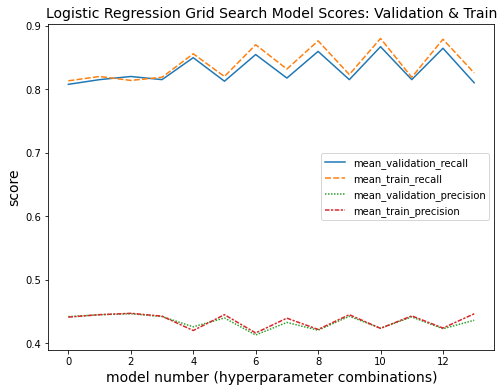

In [173]:
plt.figure(figsize=(8,6))
sns.lineplot(data =lr_grid_scores[['mean_validation_recall','mean_train_recall',
                                   'mean_validation_precision','mean_train_precision']])
plt.legend(loc=5)#bbox_to_anchor=(1.05,1),
# plt.xlim(0,10)
# plt.xticks(np.arange(0,10,1))
plt.xlabel('model number (hyperparameter combinations)', fontsize = 14)
plt.ylabel('score', fontsize = 14)
plt.title('Logistic Regression Grid Search Model Scores: Validation & Train', fontsize = 14)
plt.savefig('../output/lr_gridsearch_scores_l1l2_validation_train_4score_dropDurationMedianIP.png', 
            bbox_inches='tight')

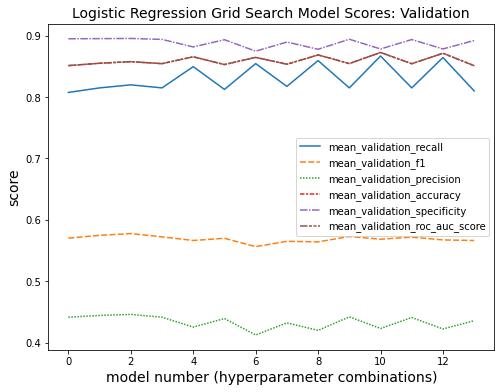

In [177]:
plt.figure(figsize=(8,6))
sns.lineplot(data =lr_grid_scores_validation)
plt.legend(loc=5)#bbox_to_anchor=(1.05,1),
plt.xlabel('model number (hyperparameter combinations)', fontsize = 14)
plt.ylabel('score', fontsize = 14)
plt.title('Logistic Regression Grid Search Model Scores: Validation', fontsize = 14)
plt.savefig('../output/lr_gridsearch_scores_l1l2_validation_dropDurationMedianIP.png', bbox_inches='tight')

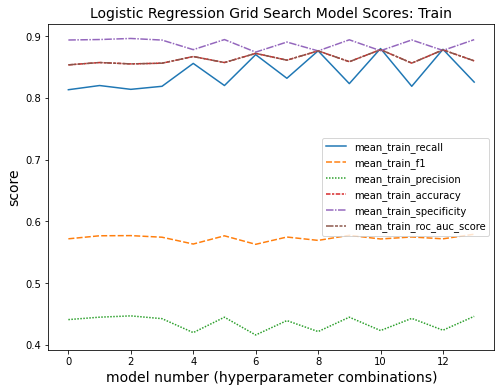

In [179]:
plt.figure(figsize=(8,6))
sns.lineplot(data =lr_grid_scores_train)
plt.legend(loc=5) #bbox_to_anchor=(1.05,1), 
plt.xlabel('model number (hyperparameter combinations)', fontsize = 14)
plt.ylabel('score', fontsize = 14)
plt.title('Logistic Regression Grid Search Model Scores: Train', fontsize = 14)
plt.savefig('../output/lr_gridsearch_scores_l1l2_train_dropDurationMedianIP.png', bbox_inches='tight')

### best LR model

In [798]:
best_row = lr_grid_scores.mean_test_recall.idxmax()
worst_row = lr_grid_scores.mean_test_recall.idxmin()
print('best lr row number', best_row)
print('worst lr row number', worst_row)
# print('best lr', lr_grid_scores.params[best_row], 'mean_test_recall', round(lr_grid_scores.mean_test_recall[best_row], 4))
print('best lr', lr_grid_scores.params[best_row])
display(lr_grid_scores[lr_grid_scores.columns[lr_grid_scores.columns.str.contains('mean_test')]].iloc[[best_row,]])
display(lr_grid_scores[lr_grid_scores.columns[lr_grid_scores.columns.str.contains('mean_train')]].iloc[[best_row,]])

best lr row number 6
worst lr row number 0
best lr {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


,mean_test_recall,mean_test_f1,mean_test_precision,mean_test_accuracy,mean_test_specificity,mean_test_roc_auc_score
6,0.874074,0.593028,0.448837,0.881593,0.889113,0.881593


,mean_train_recall,mean_train_f1,mean_train_precision,mean_train_accuracy,mean_train_specificity,mean_train_roc_auc_score
6,0.893827,0.604445,0.456662,0.891981,0.890135,0.891981


[[2930, 503], [37, 316]]

              precision    recall  f1-score   support

           0       0.91      0.86      0.88      3923
           1       0.09      0.14      0.11       405

    accuracy                           0.79      4328
   macro avg       0.50      0.50      0.50      4328
weighted avg       0.83      0.79      0.81      4328



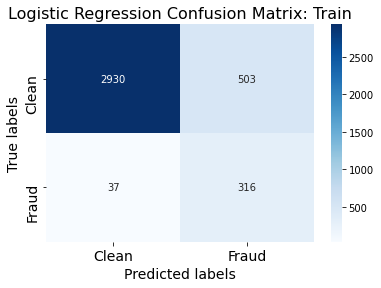

In [183]:
# Zack's best model cm numbers: just to plot
# LR confusion matrix: Train
# use numbers from Zack's model
cm = [[2930, 503], [37, 316]] # train
display(cm)

print(classification_report(ytrain.array, ypred))

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt='g')
ax.set_xlabel('Predicted labels', fontsize=14)
ax.set_ylabel('True labels', fontsize=14)
ax.xaxis.set_ticklabels(['Clean','Fraud', ], fontsize=14)
ax.yaxis.set_ticklabels(['Clean','Fraud',], fontsize=14)
ax.set_title('Logistic Regression Confusion Matrix: Train', fontsize=16)

plt.savefig('../output/lr_cm_train_heatmap_dropDurationMedianIP_zack.png')

[[1285, 186], [16, 136]]

              precision    recall  f1-score   support

           0       0.91      0.86      0.88      3923
           1       0.09      0.14      0.11       405

    accuracy                           0.79      4328
   macro avg       0.50      0.50      0.50      4328
weighted avg       0.83      0.79      0.81      4328



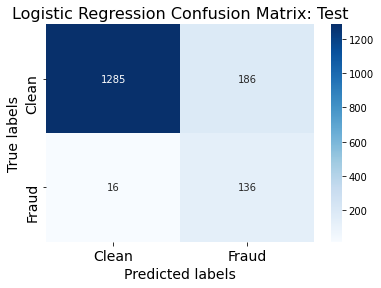

In [184]:
# Zack's best model cm numbers: just to plot
# LR confusion matrix: Test
# use numbers from Zack's model
cm = [[1285, 186], [16, 136]] # test
display(cm)

print(classification_report(ytrain.array, ypred))

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt='g')
ax.set_xlabel('Predicted labels', fontsize=14)
ax.set_ylabel('True labels', fontsize=14)
ax.xaxis.set_ticklabels(['Clean','Fraud', ], fontsize=14)
ax.yaxis.set_ticklabels(['Clean','Fraud',], fontsize=14)
ax.set_title('Logistic Regression Confusion Matrix: Test', fontsize=16)

plt.savefig('../output/lr_cm_test_heatmap_dropDurationMedianIP_zack.png')

In [201]:
# Zack's grid search best LR model
lr_best_zack = LogisticRegression(penalty='l1', C=0.01, solver='liblinear')
lr_best_zack.fit(xtrain, ytrain)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [208]:
# Lu's grid search best LR model
lr_best_lu = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
lr_best_lu.fit(xtrain, ytrain)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

array([[3871,   52],
       [ 209,  196]])

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3923
           1       0.79      0.48      0.60       405

    accuracy                           0.94      4328
   macro avg       0.87      0.74      0.78      4328
weighted avg       0.93      0.94      0.93      4328



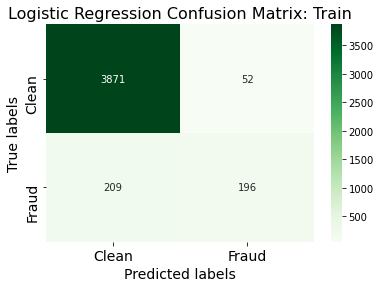

In [212]:
# Zack best LR CM based on Lu's data: Train
# ypred_train = lr_best_zack.predict(xtrain)
ypred_train = lr_best_lu.predict(xtrain)

labels = np.unique(ytrain)
cm = confusion_matrix(ytrain, ypred_train, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
display(cm)

print(classification_report(ytrain.array, ypred_train))

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Greens', fmt='g')
ax.set_xlabel('Predicted labels', fontsize=14)
ax.set_ylabel('True labels', fontsize=14)
ax.xaxis.set_ticklabels(['Clean','Fraud', ], fontsize=14)
ax.yaxis.set_ticklabels(['Clean','Fraud',], fontsize=14)
ax.set_title('Logistic Regression Confusion Matrix: Train', fontsize=16)

# plt.savefig('../output/lr_best_zack_cm_train_dropDurationMedianIP.png')
# plt.savefig('../output/lr_best_lu_cm_train_dropDurationMedianIP.png')

array([[964,  17],
       [ 59,  42]])

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       981
           1       0.71      0.42      0.53       101

    accuracy                           0.93      1082
   macro avg       0.83      0.70      0.74      1082
weighted avg       0.92      0.93      0.92      1082



Text(0.5, 1.0, 'Logistic Regression Confusion Matrix: Test')

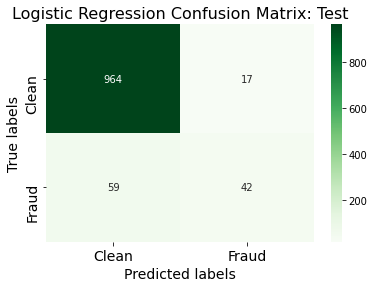

In [213]:
# Zack best LR CM based on Lu's data: Test
# ypred_test = lr_best_zack.predict(xtest)
ypred_test = lr_best_lu.predict(xtest)

labels = np.unique(ytest)
cm = confusion_matrix(ytest, ypred_test, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
display(cm)

print(classification_report(ytest.array, ypred_test))

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Greens', fmt='g')
ax.set_xlabel('Predicted labels', fontsize=14)
ax.set_ylabel('True labels', fontsize=14)
ax.xaxis.set_ticklabels(['Clean','Fraud', ], fontsize=14)
ax.yaxis.set_ticklabels(['Clean','Fraud',], fontsize=14)
ax.set_title('Logistic Regression Confusion Matrix: Test', fontsize=16)

# plt.savefig('../output/lr_best_zack_cm_test_dropDurationMedianIP.png')
# plt.savefig('../output/lr_best_lu_cm_test_dropDurationMedianIP.png')

### visualzaiton of linearity

#### probability

In [232]:
# best to use PC1, for now try the most important feature TotalRev instead
ypred_prob_train = pd.DataFrame(lr_best_lu.predict_proba(xtrain), index=xtrain.index).rename(columns={0:'no', 1:'yes'})
ypred_prob_train['odds_yes'] = np.exp(ypred_prob_train.yes)
ypred_prob_train['odds_no'] = np.exp(ypred_prob_train.no)
display(ypred_prob_train.head())

,no,yes,odds_yes,odds_no
Provider,,,,
PRV54239,0.985996,0.014004,1.014103,2.680480
PRV53376,0.979159,0.020841,1.021060,2.662216
PRV55143,0.970718,0.029282,1.029715,2.639839
PRV57346,0.984701,0.015299,1.015417,2.677011
PRV53156,0.989043,0.010957,1.011017,2.688661


,no,yes,odds_yes,odds_no,TotalRev
Provider,,,,,
PRV54239,0.985996,0.014004,1.014103,2.680480,21160
PRV53376,0.979159,0.020841,1.021060,2.662216,28500
PRV55143,0.970718,0.029282,1.029715,2.639839,11068
PRV57346,0.984701,0.015299,1.015417,2.677011,152120
PRV53156,0.989043,0.010957,1.011017,2.688661,6610


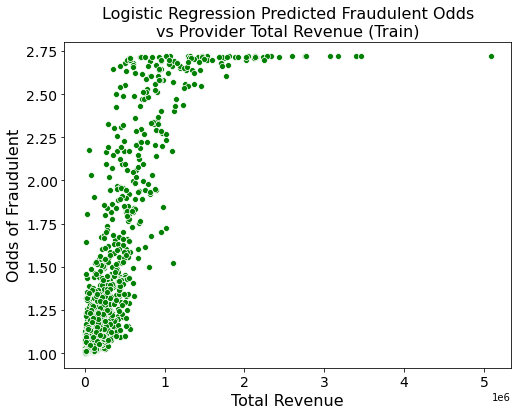

In [266]:
df_prob_train_totalrev = ypred_prob_train.merge(df_dum_drop[['TotalRev']], left_index=True, right_index=True)
display(df_prob_train_totalrev.head())

plt.figure(figsize=(8,6))
k = sns.scatterplot(x = 'TotalRev', y = 'odds_yes', data = df_prob_train_totalrev, color = 'green')
# k.set(xscale = 'log')
plt.title('Logistic Regression Predicted Fraudulent Odds\nvs Provider Total Revenue (Train)', fontsize = 16)
plt.xlabel('Total Revenue', fontsize = 16)
plt.ylabel('Odds of Fraudulent', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
# plt.xlim(0,1.5e6)

plt.savefig('../output/lr_odds_vs_totalrev.png')

#### prediction

In [299]:
# Feature Importance
lr_model = lr_best_zack
recall_coef = pd.DataFrame(lr_model.coef_.flatten(), index = xtrain.columns, columns = ['coefficient']).sort_values(by = 'coefficient', ascending = False)
recall_coef_abs = pd.DataFrame({'abs_coef':abs(lr_model.coef_.flatten()), 'coef': lr_model.coef_.flatten()}, index = xtrain.columns).sort_values(by = 'abs_coef', ascending = False)
recall_coef_imp = recall_coef_abs[recall_coef_abs['abs_coef']>0]

print(f"number of predictors before Lasso:", recall_coef_abs.shape[0])
print(f"number of predictors after Lasso:", recall_coef_imp.shape[0])

display(recall_coef_abs.head())

number of predictors before Lasso: 45
number of predictors after Lasso: 12


,abs_coef,coef
DurationMeanIP,0.148987,0.148987
PtAgeMean,0.063845,-0.063845
NumPtsIP,0.057558,-0.057558
NumOfPt,0.007002,-0.007002
PtAgeMedian,0.003596,-0.003596


,PotentialFraud,DurationMeanIP
Provider,,
PRV51001,0,5.000000
PRV51003,1,5.161290
PRV51004,0,0.000000
PRV51005,1,0.000000
PRV51007,0,5.333333


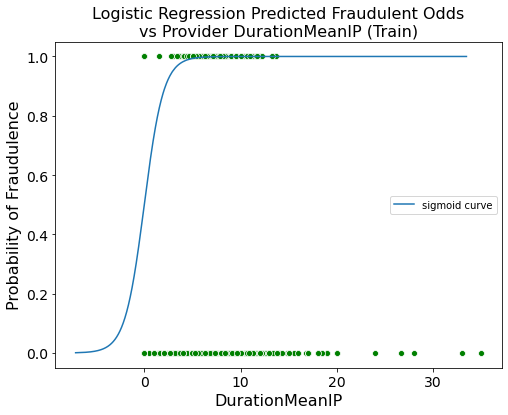

In [329]:
# best to use PC1, for now try the most important feature TotalRev instead
feature = 'DurationMeanIP'

true_vs_feature = pd.DataFrame(y).merge(df_dum_drop[[feature]], left_index=True, right_index=True)
display(true_vs_feature.head())

plt.figure(figsize=(8,6))
k = sns.scatterplot(x = feature, y = 'PotentialFraud', data = true_vs_feature, color = 'green')
# k.set(xscale = 'log')
plt.title(f'Logistic Regression Predicted Fraudulent Odds\nvs Provider {feature} (Train)', fontsize = 16)
plt.xlabel(feature, fontsize = 16)
plt.ylabel('Probability of Fraudulence', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

values = lr_model.intercept_ + np.sum(lr_model.coef_*xtrain, axis = 1)
probas = lr_model.predict_proba(xtrain)[:,1]
values, probas = zip(*sorted(zip(values, probas)))
plt.plot(values, probas, label='sigmoid curve')
plt.legend(loc=5)

# plt.savefig('../output/lr_true_vs_feature_TotalRev.png')
# plt.savefig('../output/lr_true_vs_feature_sigmoid_TotalRev.png')

# plt.savefig('../output/lr_true_vs_feature_DurationMeanIP.png')
# plt.savefig('../output/lr_true_vs_feature_sigmoid_DurationMeanIP.png')

# plt.savefig('../output/lr_true_vs_feature_NumOfPt.png')
# plt.savefig('../output/lr_true_vs_feature_sigmoid_NumOfPt.png')

## Random Forest

### train test split for random forest

In [31]:
# remove Duration MedianIP
df_dum_drop = df_dum.drop(['DurationMedianIP'], axis=1)

In [32]:
x = df_dum_drop.drop(['PotentialFraud'], axis = 1)
y = df_dum_drop.PotentialFraud
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=4, stratify=y)

In [34]:
# remove Duration MedianIP
display(xtrain.shape)
'DurationMedianIP' in xtrain.columns

(4328, 45)

False

In [ ]:
# for flag 1,0
print('ytrain class ave', ytrain.mean())
print('ytest class ave', ytest.mean())

print(x.shape)
print(xtrain.shape)
print(xtest.shape)

### coarse grid search of RF

In [37]:
rf = RandomForestClassifier(random_state=4, oob_score=True, class_weight='balanced')

In [38]:
print('num of observations', xtrain.shape[0])
print('num of features', xtrain.shape[1])

max_features_1 = np.arange(2,int(xtrain.shape[1]/2),4)
print('max_features', max_features_1)
min_split_1 = np.arange(5,21,5)
print('min_samples_split', min_split_1) # use one, min_leaf & min_split are smiliar

num of observations 4328
num of features 45
max_features [ 2  6 10 14 18]
min_samples_split [ 5 10 15 20]


In [39]:
rf_params = [{'max_features': max_features_1,'n_estimators': [200, 500],
             'min_samples_split': min_split_1}]

kf5 = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

scores = { 'recall': make_scorer(recall_score, pos_label = 1, average = 'binary'), 
          'f1': make_scorer(f1_score, pos_label = 1, average = 'binary'), # use binary not weighted
         'precision': make_scorer(precision_score, pos_label = 1, average = 'binary'),
         'accuracy': make_scorer(accuracy_score), # not use balanced_accurarcy_score
         'specificity': make_scorer(recall_score, pos_label = 0, average = 'binary'), 
         'roc_auc_score': make_scorer(roc_auc_score, average = 'macro')
         }


rf_grid = GridSearchCV(estimator=rf, param_grid=rf_params, return_train_score=True, 
                       cv = kf5, verbose=2, scoring=scores, refit=False)

%time rf_grid.fit(xtrain, ytrain)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] max_features=2, min_samples_split=5, n_estimators=200 ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=2, min_samples_split=5, n_estimators=200, total=   1.5s
[CV] max_features=2, min_samples_split=5, n_estimators=200 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  max_features=2, min_samples_split=5, n_estimators=200, total=   1.3s
[CV] max_features=2, min_samples_split=5, n_estimators=200 ...........
[CV]  max_features=2, min_samples_split=5, n_estimators=200, total=   1.0s
[CV] max_features=2, min_samples_split=5, n_estimators=200 ...........
[CV]  max_features=2, min_samples_split=5, n_estimators=200, total=   0.9s
[CV] max_features=2, min_samples_split=5, n_estimators=200 ...........
[CV]  max_features=2, min_samples_split=5, n_estimators=200, total=   0.9s
[CV] max_features=2, min_samples_split=5, n_estimators=500 ...........
[CV]  max_features=2, min_samples_split=5, n_estimators=500, total=   2.3s
[CV] max_features=2, min_samples_split=5, n_estimators=500 ...........
[CV]  max_features=2, min_samples_split=5, n_estimators=500, total=   3.6s
[CV] max_features=2, min_samples_split=5, n_estimators=500 ...........
[CV]  max_features=2, min_samples_split=5, n_estimators=500, total=   3.1s
[CV] max_features=2, min_samples_split=5, n_estim

[CV]  max_features=6, min_samples_split=10, n_estimators=500, total=   4.0s
[CV] max_features=6, min_samples_split=10, n_estimators=500 ..........
[CV]  max_features=6, min_samples_split=10, n_estimators=500, total=   3.8s
[CV] max_features=6, min_samples_split=10, n_estimators=500 ..........
[CV]  max_features=6, min_samples_split=10, n_estimators=500, total=   3.3s
[CV] max_features=6, min_samples_split=15, n_estimators=200 ..........
[CV]  max_features=6, min_samples_split=15, n_estimators=200, total=   1.4s
[CV] max_features=6, min_samples_split=15, n_estimators=200 ..........
[CV]  max_features=6, min_samples_split=15, n_estimators=200, total=   1.4s
[CV] max_features=6, min_samples_split=15, n_estimators=200 ..........
[CV]  max_features=6, min_samples_split=15, n_estimators=200, total=   1.4s
[CV] max_features=6, min_samples_split=15, n_estimators=200 ..........
[CV]  max_features=6, min_samples_split=15, n_estimators=200, total=   1.4s
[CV] max_features=6, min_samples_split=15,

[CV]  max_features=10, min_samples_split=20, n_estimators=200, total=   1.9s
[CV] max_features=10, min_samples_split=20, n_estimators=200 .........
[CV]  max_features=10, min_samples_split=20, n_estimators=200, total=   1.8s
[CV] max_features=10, min_samples_split=20, n_estimators=500 .........
[CV]  max_features=10, min_samples_split=20, n_estimators=500, total=   4.1s
[CV] max_features=10, min_samples_split=20, n_estimators=500 .........
[CV]  max_features=10, min_samples_split=20, n_estimators=500, total=   4.3s
[CV] max_features=10, min_samples_split=20, n_estimators=500 .........
[CV]  max_features=10, min_samples_split=20, n_estimators=500, total=   4.2s
[CV] max_features=10, min_samples_split=20, n_estimators=500 .........
[CV]  max_features=10, min_samples_split=20, n_estimators=500, total=   4.5s
[CV] max_features=10, min_samples_split=20, n_estimators=500 .........
[CV]  max_features=10, min_samples_split=20, n_estimators=500, total=   4.3s
[CV] max_features=14, min_samples_s

[CV]  max_features=18, min_samples_split=5, n_estimators=500, total=   6.8s
[CV] max_features=18, min_samples_split=10, n_estimators=200 .........
[CV]  max_features=18, min_samples_split=10, n_estimators=200, total=   2.6s
[CV] max_features=18, min_samples_split=10, n_estimators=200 .........
[CV]  max_features=18, min_samples_split=10, n_estimators=200, total=   2.6s
[CV] max_features=18, min_samples_split=10, n_estimators=200 .........
[CV]  max_features=18, min_samples_split=10, n_estimators=200, total=   2.7s
[CV] max_features=18, min_samples_split=10, n_estimators=200 .........
[CV]  max_features=18, min_samples_split=10, n_estimators=200, total=   2.7s
[CV] max_features=18, min_samples_split=10, n_estimators=200 .........
[CV]  max_features=18, min_samples_split=10, n_estimators=200, total=   2.5s
[CV] max_features=18, min_samples_split=10, n_estimators=500 .........
[CV]  max_features=18, min_samples_split=10, n_estimators=500, total=   6.5s
[CV] max_features=18, min_samples_sp

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 11.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=...
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score, pos_label=1, average=binary),
                      'precision': make_scorer(p

In [41]:
keys = list(rf_grid.cv_results_.keys())
mean_test = [s for s in keys if 'mean_test' in s]
mean_train = [s for s in keys if 'mean_train' in s]
print(mean_test)
print(mean_train)

['mean_test_recall', 'mean_test_f1', 'mean_test_precision', 'mean_test_accuracy', 'mean_test_specificity', 'mean_test_roc_auc_score']
['mean_train_recall', 'mean_train_f1', 'mean_train_precision', 'mean_train_accuracy', 'mean_train_specificity', 'mean_train_roc_auc_score']


In [58]:
rf_grid_scores = pd.DataFrame({'params': rf_grid.cv_results_['params'], 
              'mean_validation_recall': rf_grid.cv_results_['mean_test_recall'],
              'mean_train_recall': rf_grid.cv_results_['mean_train_recall'],
              'mean_validation_f1': rf_grid.cv_results_['mean_test_f1'],
              'mean_train_f1': rf_grid.cv_results_['mean_train_f1'],
              'mean_validation_precision': rf_grid.cv_results_['mean_test_precision'],
              'mean_train_precision': rf_grid.cv_results_['mean_train_precision'],
              'mean_validation_accuracy': rf_grid.cv_results_['mean_test_accuracy'],
              'mean_train_accuracy': rf_grid.cv_results_['mean_train_accuracy'],
              'mean_validation_specificity': rf_grid.cv_results_['mean_test_specificity'],
              'mean_train_specificity': rf_grid.cv_results_['mean_train_specificity'], 
              'mean_validation_roc_auc_score': rf_grid.cv_results_['mean_test_roc_auc_score'],
              'mean_train_roc_auc_score': rf_grid.cv_results_['mean_train_roc_auc_score']
             })
rf_grid_scores.to_csv('../output/rf_grid_coarse_scores_dropDurationMedianIP.csv')
rf_grid_scores

,params,mean_validation_recall,mean_train_recall,mean_validation_f1,mean_train_f1,mean_validation_precision,mean_train_precision,mean_validation_accuracy,mean_train_accuracy,mean_validation_specificity,mean_train_specificity,mean_validation_roc_auc_score,mean_train_roc_auc_score
0,"{'max_features': 2, 'min_samples_split': 5, 'n...",0.540741,0.998765,0.605364,0.987189,0.689767,0.975889,0.934151,0.997574,0.974764,0.997451,0.757752,0.998108
1,"{'max_features': 2, 'min_samples_split': 5, 'n...",0.530864,1.000000,0.598091,0.986302,0.686679,0.972976,0.933226,0.997401,0.974763,0.997132,0.752814,0.998566
2,"{'max_features': 2, 'min_samples_split': 10, '...",0.639506,0.982716,0.629853,0.901764,0.621844,0.833265,0.929528,0.979956,0.959468,0.979671,0.799487,0.981194
3,"{'max_features': 2, 'min_samples_split': 10, '...",0.639506,0.987037,0.626830,0.903421,0.616046,0.832944,0.928603,0.980245,0.958448,0.979544,0.798977,0.983290
4,"{'max_features': 2, 'min_samples_split': 15, '...",0.701235,0.961728,0.629433,0.830055,0.571395,0.730105,0.922597,0.963147,0.945449,0.963293,0.823342,0.962511
5,"{'max_features': 2, 'min_samples_split': 15, '...",0.720988,0.964815,0.640796,0.830503,0.577185,0.729024,0.924214,0.963147,0.945194,0.962975,0.833091,0.963895
6,"{'max_features': 2, 'min_samples_split': 20, '...",0.745679,0.949383,0.628108,0.779362,0.542683,0.661015,0.917284,0.949688,0.934999,0.949720,0.840339,0.949551
7,"{'max_features': 2, 'min_samples_split': 20, '...",0.745679,0.950000,0.627383,0.780278,0.541634,0.662047,0.917053,0.949919,0.934744,0.949911,0.840211,0.949955
8,"{'max_features': 6, 'min_samples_split': 5, 'n...",0.525926,1.000000,0.604699,0.994477,0.714968,0.989017,0.935767,0.998960,0.978076,0.998853,0.752001,0.999426
9,"{'max_features': 6, 'min_samples_split': 5, 'n...",0.520988,1.000000,0.600832,0.995393,0.712578,0.990829,0.935304,0.999134,0.978076,0.999044,0.749532,0.999522


In [74]:
best_row = rf_grid_scores.mean_validation_recall.idxmax()
worst_row = rf_grid_scores.mean_validation_recall.idxmin()
print('best RF row number', best_row)
print('worst RF row number', worst_row)
print('best RF coarse', rf_grid_scores.params[best_row])
display(rf_grid_scores[rf_grid_scores.columns[rf_grid_scores.columns.str.contains('mean_validation')]].iloc[[best_row,]])
display(rf_grid_scores[rf_grid_scores.columns[rf_grid_scores.columns.str.contains('mean_train')]].iloc[[best_row,]])

rf_coarse_mf = rf_grid_scores.params[best_row]['max_features']
rf_coarse_mss = rf_grid_scores.params[best_row]['min_samples_split']
rf_coarse_ne = rf_grid_scores.params[best_row]['n_estimators']
print(rf_coarse_mf, rf_coarse_mss, rf_coarse_ne)

best RF row number 6
worst RF row number 32
best RF coarse {'max_features': 2, 'min_samples_split': 20, 'n_estimators': 200}


,mean_validation_recall,mean_validation_f1,mean_validation_precision,mean_validation_accuracy,mean_validation_specificity,mean_validation_roc_auc_score
6,0.745679,0.628108,0.542683,0.917284,0.934999,0.840339


,mean_train_recall,mean_train_f1,mean_train_precision,mean_train_accuracy,mean_train_specificity,mean_train_roc_auc_score
6,0.949383,0.779362,0.661015,0.949688,0.94972,0.949551


2 20 200


In [65]:
# best RF model fit: coarse grid search
rf_best_coarse = RandomForestClassifier(oob_score=True, class_weight='balanced', 
                                        max_features=rf_coarse_mf, 
                                        min_samples_split=rf_coarse_mss, 
                                        n_estimators=rf_coarse_ne)
rf_best_coarse.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

,0,1
0,3733,190
1,21,384


              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3923
           1       0.67      0.95      0.78       405

    accuracy                           0.95      4328
   macro avg       0.83      0.95      0.88      4328
weighted avg       0.96      0.95      0.95      4328



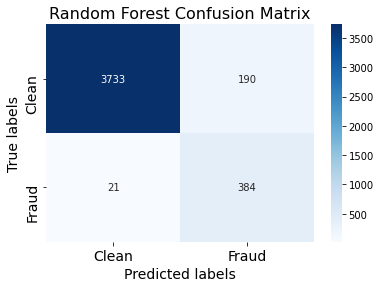

In [67]:
# confusion matrix
ypred = rf_best_coarse.predict(xtrain)

labels = np.unique(ytrain)
cm = confusion_matrix(ytrain, ypred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
display(cm_df)

print(classification_report(ytrain.array, ypred))

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt='g')
ax.set_xlabel('Predicted labels', fontsize=14)
ax.set_ylabel('True labels', fontsize=14)
ax.set_title('Random Forest Confusion Matrix', fontsize=16)
ax.xaxis.set_ticklabels(['Clean','Fraud', ], fontsize=14)
ax.yaxis.set_ticklabels(['Clean','Fraud',], fontsize=14)
plt.savefig('../output/rf_grid_coarse_cm_heatmap_dropDurationMedianIP.png')

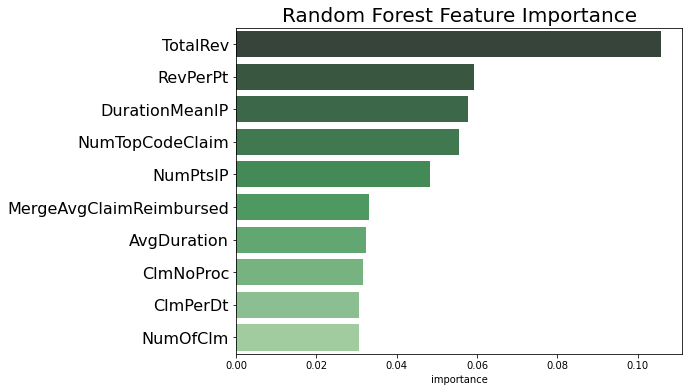

In [68]:
rf_feature_imp = pd.DataFrame(data = rf_best_coarse.feature_importances_, index=xtrain.columns, 
                              columns=['importance']).sort_values(by = 'importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(y = rf_feature_imp.index[:10], x = 'importance', data = rf_feature_imp[:10],palette=sns.color_palette('Greens_d', n_colors=10)) #Greens_d
plt.title('Random Forest Feature Importance', fontsize=20)
plt.yticks(fontsize = 16)

plt.savefig('../output/rf_grid_coarse_feature_importance_green_dropDurationMedianIP.png', bbox_inches='tight')
rf_feature_imp.to_csv('../output/rf_grid_coarse_feature_importance.csv')

In [70]:
rf_grid_scores_test = rf_grid_scores[rf_grid_scores.columns[rf_grid_scores.columns.str.contains('validation')]]
display(rf_grid_scores_test)
rf_grid_scores_train = rf_grid_scores[rf_grid_scores.columns[rf_grid_scores.columns.str.contains('train')]]
display(rf_grid_scores_train)

,mean_validation_recall,mean_validation_f1,mean_validation_precision,mean_validation_accuracy,mean_validation_specificity,mean_validation_roc_auc_score
0,0.540741,0.605364,0.689767,0.934151,0.974764,0.757752
1,0.530864,0.598091,0.686679,0.933226,0.974763,0.752814
2,0.639506,0.629853,0.621844,0.929528,0.959468,0.799487
3,0.639506,0.626830,0.616046,0.928603,0.958448,0.798977
4,0.701235,0.629433,0.571395,0.922597,0.945449,0.823342
5,0.720988,0.640796,0.577185,0.924214,0.945194,0.833091
6,0.745679,0.628108,0.542683,0.917284,0.934999,0.840339
7,0.745679,0.627383,0.541634,0.917053,0.934744,0.840211
8,0.525926,0.604699,0.714968,0.935767,0.978076,0.752001
9,0.520988,0.600832,0.712578,0.935304,0.978076,0.749532


,mean_train_recall,mean_train_f1,mean_train_precision,mean_train_accuracy,mean_train_specificity,mean_train_roc_auc_score
0,0.998765,0.987189,0.975889,0.997574,0.997451,0.998108
1,1.000000,0.986302,0.972976,0.997401,0.997132,0.998566
2,0.982716,0.901764,0.833265,0.979956,0.979671,0.981194
3,0.987037,0.903421,0.832944,0.980245,0.979544,0.983290
4,0.961728,0.830055,0.730105,0.963147,0.963293,0.962511
5,0.964815,0.830503,0.729024,0.963147,0.962975,0.963895
6,0.949383,0.779362,0.661015,0.949688,0.949720,0.949551
7,0.950000,0.780278,0.662047,0.949919,0.949911,0.949955
8,1.000000,0.994477,0.989017,0.998960,0.998853,0.999426
9,1.000000,0.995393,0.990829,0.999134,0.999044,0.999522


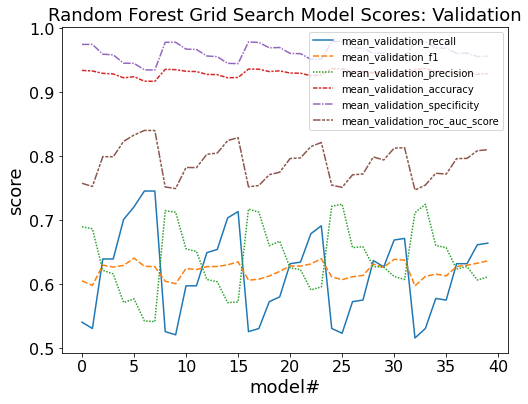

In [71]:
plt.figure(figsize=(8,6))
sns.lineplot(data =rf_grid_scores_test)
plt.legend( loc=1) #bbox_to_anchor=(1.05,1)
plt.xlabel('model#', fontsize=18)
plt.ylabel('score', fontsize=18)
plt.title('Random Forest Grid Search Model Scores: Validation', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('../output/rf_grid_coarse_scores_validation_dropDurationMedianIP.png', bbox_inches='tight')

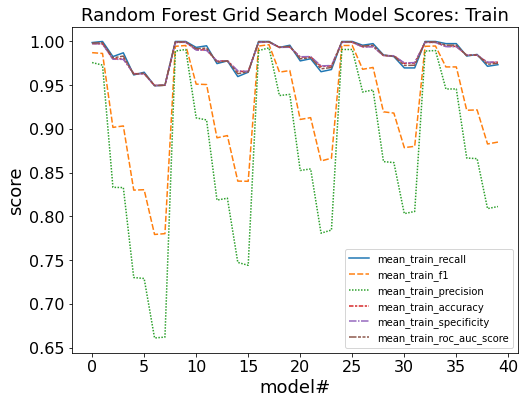

In [73]:
plt.figure(figsize=(8,6))
sns.lineplot(data =rf_grid_scores_train)
plt.legend(loc=4) #bbox_to_anchor=(1.05,1)
plt.xlabel('model#', fontsize=18)
plt.ylabel('score', fontsize=18)
plt.title('Random Forest Grid Search Model Scores: Train', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('../output/rf_grid_coarse_scores_train_dropDurationMedianIP.png', bbox_inches='tight')

### fine gridsearch of random forest

In [80]:
xtrain.shape

(4328, 45)

In [84]:
print('best RF coarse', rf_grid_scores.params[best_row])
max_features_2 = np.arange(1,5,1)
print('max_features', max_features_2)
min_split_2 = np.arange(16, 25, 1)
print('min_split', min_split_2)
estimators = [200,500, 1000]
print('n_estimator', estimators)

best RF coarse {'max_features': 2, 'min_samples_split': 20, 'n_estimators': 200}
max_features [1 2 3 4]
min_split [16 17 18 19 20 21 22 23 24]
n_estimator [200, 500, 1000]


In [85]:
rf_params = [{'max_features': max_features_2,'n_estimators': estimators,
             'min_samples_split': min_split_2}] 

kf5 = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

scores = { 'recall': make_scorer(recall_score, pos_label = 1, average = 'binary'), 
          'f1': make_scorer(f1_score, pos_label = 1, average = 'binary'),
         'precision': make_scorer(precision_score, pos_label = 1, average = 'binary'),
         'accuracy': make_scorer(accuracy_score), 
         'specificity': make_scorer(recall_score, pos_label = 0, average = 'binary'), 
         'roc_auc_score': make_scorer(roc_auc_score, average = 'macro')
         }


rf_grid_fine = GridSearchCV(estimator=rf, param_grid=rf_params, return_train_score=True, 
                       cv = kf5, verbose=2, scoring=scores, refit=False)

%time rf_grid_fine.fit(xtrain, ytrain)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] max_features=1, min_samples_split=16, n_estimators=200 ..........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=1, min_samples_split=16, n_estimators=200, total=   1.0s
[CV] max_features=1, min_samples_split=16, n_estimators=200 ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV]  max_features=1, min_samples_split=16, n_estimators=200, total=   0.9s
[CV] max_features=1, min_samples_split=16, n_estimators=200 ..........
[CV]  max_features=1, min_samples_split=16, n_estimators=200, total=   0.8s
[CV] max_features=1, min_samples_split=16, n_estimators=200 ..........
[CV]  max_features=1, min_samples_split=16, n_estimators=200, total=   0.9s
[CV] max_features=1, min_samples_split=16, n_estimators=200 ..........
[CV]  max_features=1, min_samples_split=16, n_estimators=200, total=   1.0s
[CV] max_features=1, min_samples_split=16, n_estimators=500 ..........
[CV]  max_features=1, min_samples_split=16, n_estimators=500, total=   2.5s
[CV] max_features=1, min_samples_split=16, n_estimators=500 ..........
[CV]  max_features=1, min_samples_split=16, n_estimators=500, total=   2.2s
[CV] max_features=1, min_samples_split=16, n_estimators=500 ..........
[CV]  max_features=1, min_samples_split=16, n_estimators=500, total=   2.1s
[CV] max_features=1, min_samples_split=16,

[CV]  max_features=1, min_samples_split=19, n_estimators=1000, total=   4.1s
[CV] max_features=1, min_samples_split=19, n_estimators=1000 .........
[CV]  max_features=1, min_samples_split=19, n_estimators=1000, total=   4.4s
[CV] max_features=1, min_samples_split=19, n_estimators=1000 .........
[CV]  max_features=1, min_samples_split=19, n_estimators=1000, total=   4.2s
[CV] max_features=1, min_samples_split=20, n_estimators=200 ..........
[CV]  max_features=1, min_samples_split=20, n_estimators=200, total=   0.8s
[CV] max_features=1, min_samples_split=20, n_estimators=200 ..........
[CV]  max_features=1, min_samples_split=20, n_estimators=200, total=   0.9s
[CV] max_features=1, min_samples_split=20, n_estimators=200 ..........
[CV]  max_features=1, min_samples_split=20, n_estimators=200, total=   0.9s
[CV] max_features=1, min_samples_split=20, n_estimators=200 ..........
[CV]  max_features=1, min_samples_split=20, n_estimators=200, total=   0.9s
[CV] max_features=1, min_samples_split=

[CV]  max_features=1, min_samples_split=23, n_estimators=500, total=   2.4s
[CV] max_features=1, min_samples_split=23, n_estimators=500 ..........
[CV]  max_features=1, min_samples_split=23, n_estimators=500, total=   2.2s
[CV] max_features=1, min_samples_split=23, n_estimators=1000 .........
[CV]  max_features=1, min_samples_split=23, n_estimators=1000, total=   4.5s
[CV] max_features=1, min_samples_split=23, n_estimators=1000 .........
[CV]  max_features=1, min_samples_split=23, n_estimators=1000, total=   4.2s
[CV] max_features=1, min_samples_split=23, n_estimators=1000 .........
[CV]  max_features=1, min_samples_split=23, n_estimators=1000, total=   4.6s
[CV] max_features=1, min_samples_split=23, n_estimators=1000 .........
[CV]  max_features=1, min_samples_split=23, n_estimators=1000, total=   4.2s
[CV] max_features=1, min_samples_split=23, n_estimators=1000 .........
[CV]  max_features=1, min_samples_split=23, n_estimators=1000, total=   4.4s
[CV] max_features=1, min_samples_spli

[CV]  max_features=2, min_samples_split=18, n_estimators=200, total=   1.2s
[CV] max_features=2, min_samples_split=18, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=18, n_estimators=500, total=   2.9s
[CV] max_features=2, min_samples_split=18, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=18, n_estimators=500, total=   2.6s
[CV] max_features=2, min_samples_split=18, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=18, n_estimators=500, total=   2.7s
[CV] max_features=2, min_samples_split=18, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=18, n_estimators=500, total=   2.8s
[CV] max_features=2, min_samples_split=18, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=18, n_estimators=500, total=   2.8s
[CV] max_features=2, min_samples_split=18, n_estimators=1000 .........
[CV]  max_features=2, min_samples_split=18, n_estimators=1000, total=   5.1s
[CV] max_features=2, min_samples_split=18

[CV]  max_features=2, min_samples_split=22, n_estimators=200, total=   1.3s
[CV] max_features=2, min_samples_split=22, n_estimators=200 ..........
[CV]  max_features=2, min_samples_split=22, n_estimators=200, total=   2.7s
[CV] max_features=2, min_samples_split=22, n_estimators=200 ..........
[CV]  max_features=2, min_samples_split=22, n_estimators=200, total=   1.7s
[CV] max_features=2, min_samples_split=22, n_estimators=200 ..........
[CV]  max_features=2, min_samples_split=22, n_estimators=200, total=   2.1s
[CV] max_features=2, min_samples_split=22, n_estimators=200 ..........
[CV]  max_features=2, min_samples_split=22, n_estimators=200, total=   1.1s
[CV] max_features=2, min_samples_split=22, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=22, n_estimators=500, total=   2.7s
[CV] max_features=2, min_samples_split=22, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=22, n_estimators=500, total=   2.4s
[CV] max_features=2, min_samples_split=22,

[CV]  max_features=3, min_samples_split=16, n_estimators=1000, total=   5.2s
[CV] max_features=3, min_samples_split=16, n_estimators=1000 .........
[CV]  max_features=3, min_samples_split=16, n_estimators=1000, total=   5.1s
[CV] max_features=3, min_samples_split=16, n_estimators=1000 .........
[CV]  max_features=3, min_samples_split=16, n_estimators=1000, total=   5.4s
[CV] max_features=3, min_samples_split=16, n_estimators=1000 .........
[CV]  max_features=3, min_samples_split=16, n_estimators=1000, total=   5.1s
[CV] max_features=3, min_samples_split=17, n_estimators=200 ..........
[CV]  max_features=3, min_samples_split=17, n_estimators=200, total=   1.1s
[CV] max_features=3, min_samples_split=17, n_estimators=200 ..........
[CV]  max_features=3, min_samples_split=17, n_estimators=200, total=   1.0s
[CV] max_features=3, min_samples_split=17, n_estimators=200 ..........
[CV]  max_features=3, min_samples_split=17, n_estimators=200, total=   1.0s
[CV] max_features=3, min_samples_split

[CV]  max_features=3, min_samples_split=20, n_estimators=500, total=   2.8s
[CV] max_features=3, min_samples_split=20, n_estimators=500 ..........
[CV]  max_features=3, min_samples_split=20, n_estimators=500, total=   2.8s
[CV] max_features=3, min_samples_split=20, n_estimators=500 ..........
[CV]  max_features=3, min_samples_split=20, n_estimators=500, total=   2.8s
[CV] max_features=3, min_samples_split=20, n_estimators=1000 .........
[CV]  max_features=3, min_samples_split=20, n_estimators=1000, total=   5.5s
[CV] max_features=3, min_samples_split=20, n_estimators=1000 .........
[CV]  max_features=3, min_samples_split=20, n_estimators=1000, total=   5.3s
[CV] max_features=3, min_samples_split=20, n_estimators=1000 .........
[CV]  max_features=3, min_samples_split=20, n_estimators=1000, total=   5.1s
[CV] max_features=3, min_samples_split=20, n_estimators=1000 .........
[CV]  max_features=3, min_samples_split=20, n_estimators=1000, total=   5.2s
[CV] max_features=3, min_samples_split

[CV]  max_features=3, min_samples_split=24, n_estimators=200, total=   1.4s
[CV] max_features=3, min_samples_split=24, n_estimators=200 ..........
[CV]  max_features=3, min_samples_split=24, n_estimators=200, total=   1.3s
[CV] max_features=3, min_samples_split=24, n_estimators=500 ..........
[CV]  max_features=3, min_samples_split=24, n_estimators=500, total=   3.1s
[CV] max_features=3, min_samples_split=24, n_estimators=500 ..........
[CV]  max_features=3, min_samples_split=24, n_estimators=500, total=   4.1s
[CV] max_features=3, min_samples_split=24, n_estimators=500 ..........
[CV]  max_features=3, min_samples_split=24, n_estimators=500, total=   5.1s
[CV] max_features=3, min_samples_split=24, n_estimators=500 ..........
[CV]  max_features=3, min_samples_split=24, n_estimators=500, total=   2.8s
[CV] max_features=3, min_samples_split=24, n_estimators=500 ..........
[CV]  max_features=3, min_samples_split=24, n_estimators=500, total=   2.7s
[CV] max_features=3, min_samples_split=24,

[CV]  max_features=4, min_samples_split=18, n_estimators=1000, total=   5.9s
[CV] max_features=4, min_samples_split=19, n_estimators=200 ..........
[CV]  max_features=4, min_samples_split=19, n_estimators=200, total=   1.0s
[CV] max_features=4, min_samples_split=19, n_estimators=200 ..........
[CV]  max_features=4, min_samples_split=19, n_estimators=200, total=   1.1s
[CV] max_features=4, min_samples_split=19, n_estimators=200 ..........
[CV]  max_features=4, min_samples_split=19, n_estimators=200, total=   1.1s
[CV] max_features=4, min_samples_split=19, n_estimators=200 ..........
[CV]  max_features=4, min_samples_split=19, n_estimators=200, total=   1.1s
[CV] max_features=4, min_samples_split=19, n_estimators=200 ..........
[CV]  max_features=4, min_samples_split=19, n_estimators=200, total=   1.2s
[CV] max_features=4, min_samples_split=19, n_estimators=500 ..........
[CV]  max_features=4, min_samples_split=19, n_estimators=500, total=   2.7s
[CV] max_features=4, min_samples_split=19

[CV]  max_features=4, min_samples_split=22, n_estimators=1000, total=   5.5s
[CV] max_features=4, min_samples_split=22, n_estimators=1000 .........
[CV]  max_features=4, min_samples_split=22, n_estimators=1000, total=   5.4s
[CV] max_features=4, min_samples_split=22, n_estimators=1000 .........
[CV]  max_features=4, min_samples_split=22, n_estimators=1000, total=   6.5s
[CV] max_features=4, min_samples_split=22, n_estimators=1000 .........
[CV]  max_features=4, min_samples_split=22, n_estimators=1000, total=   5.3s
[CV] max_features=4, min_samples_split=22, n_estimators=1000 .........
[CV]  max_features=4, min_samples_split=22, n_estimators=1000, total=   5.3s
[CV] max_features=4, min_samples_split=23, n_estimators=200 ..........
[CV]  max_features=4, min_samples_split=23, n_estimators=200, total=   1.2s
[CV] max_features=4, min_samples_split=23, n_estimators=200 ..........
[CV]  max_features=4, min_samples_split=23, n_estimators=200, total=   1.2s
[CV] max_features=4, min_samples_spli

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed: 30.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=...
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score, pos_label=1, average=binary),
                      'precision': make_scorer(p

In [94]:
rf_grid_fine_scores = pd.DataFrame({'params': rf_grid_fine.cv_results_['params'], 
              'mean_validation_recall': rf_grid_fine.cv_results_['mean_test_recall'],
              'mean_train_recall': rf_grid_fine.cv_results_['mean_train_recall'],
              'mean_validation_f1': rf_grid_fine.cv_results_['mean_test_f1'],
              'mean_train_f1': rf_grid_fine.cv_results_['mean_train_f1'],
              'mean_validation_precision': rf_grid_fine.cv_results_['mean_test_precision'],
              'mean_train_precision': rf_grid_fine.cv_results_['mean_train_precision'],
              'mean_validation_accuracy': rf_grid_fine.cv_results_['mean_test_accuracy'],
              'mean_train_accuracy': rf_grid_fine.cv_results_['mean_train_accuracy'],
              'mean_validation_specificity': rf_grid_fine.cv_results_['mean_test_specificity'],
              'mean_train_specificity': rf_grid_fine.cv_results_['mean_train_specificity'], 
              'mean_validation_roc_auc_score': rf_grid_fine.cv_results_['mean_test_roc_auc_score'],
              'mean_train_roc_auc_score': rf_grid_fine.cv_results_['mean_train_roc_auc_score']
             })
rf_grid_fine_scores.to_csv('../output/rf_grid_fine_scores_dropDurationMedianIP.csv')
rf_grid_fine_scores

,params,mean_validation_recall,mean_train_recall,mean_validation_f1,mean_train_f1,mean_validation_precision,mean_train_precision,mean_validation_accuracy,mean_train_accuracy,mean_validation_specificity,mean_train_specificity,mean_validation_roc_auc_score,mean_train_roc_auc_score
0,"{'max_features': 1, 'min_samples_split': 16, '...",0.728395,0.957407,0.632750,0.803047,0.559689,0.691590,0.920749,0.956042,0.940606,0.955901,0.834501,0.956654
1,"{'max_features': 1, 'min_samples_split': 16, '...",0.720988,0.957407,0.626383,0.802834,0.554209,0.691271,0.919362,0.955984,0.939842,0.955837,0.830415,0.956622
2,"{'max_features': 1, 'min_samples_split': 16, '...",0.723457,0.959877,0.627388,0.803649,0.554502,0.691178,0.919361,0.956100,0.939586,0.955710,0.831522,0.957793
3,"{'max_features': 1, 'min_samples_split': 17, '...",0.725926,0.953086,0.623371,0.789787,0.546494,0.674285,0.917744,0.952518,0.937547,0.952460,0.831736,0.952773
4,"{'max_features': 1, 'min_samples_split': 17, '...",0.725926,0.954938,0.621342,0.794772,0.543385,0.680641,0.917052,0.953847,0.936783,0.953734,0.831355,0.954336
5,"{'max_features': 1, 'min_samples_split': 17, '...",0.728395,0.954938,0.626910,0.795395,0.550705,0.681556,0.918669,0.954020,0.938312,0.953926,0.833353,0.954432
6,"{'max_features': 1, 'min_samples_split': 18, '...",0.730864,0.951852,0.621689,0.782573,0.541154,0.664448,0.916591,0.950497,0.935763,0.950357,0.833314,0.951104
7,"{'max_features': 1, 'min_samples_split': 18, '...",0.735802,0.950617,0.625249,0.781942,0.543806,0.664120,0.917283,0.950381,0.936018,0.950357,0.835910,0.950487
8,"{'max_features': 1, 'min_samples_split': 18, '...",0.738272,0.952469,0.627195,0.783068,0.545368,0.664841,0.917745,0.950612,0.936273,0.950421,0.837272,0.951445
9,"{'max_features': 1, 'min_samples_split': 19, '...",0.735802,0.950617,0.619378,0.773699,0.535255,0.652333,0.915203,0.947955,0.933723,0.947680,0.834763,0.949149


In [95]:
rf_grid_fine_scores_validation = rf_grid_fine_scores[rf_grid_fine_scores.columns[rf_grid_fine_scores.columns.str.contains('validation')]]
display(rf_grid_fine_scores_validation)
rf_grid_fine_scores_train = rf_grid_fine_scores[rf_grid_fine_scores.columns[rf_grid_fine_scores.columns.str.contains('train')]]
display(rf_grid_fine_scores_train)

,mean_validation_recall,mean_validation_f1,mean_validation_precision,mean_validation_accuracy,mean_validation_specificity,mean_validation_roc_auc_score
0,0.728395,0.632750,0.559689,0.920749,0.940606,0.834501
1,0.720988,0.626383,0.554209,0.919362,0.939842,0.830415
2,0.723457,0.627388,0.554502,0.919361,0.939586,0.831522
3,0.725926,0.623371,0.546494,0.917744,0.937547,0.831736
4,0.725926,0.621342,0.543385,0.917052,0.936783,0.831355
5,0.728395,0.626910,0.550705,0.918669,0.938312,0.833353
6,0.730864,0.621689,0.541154,0.916591,0.935763,0.833314
7,0.735802,0.625249,0.543806,0.917283,0.936018,0.835910
8,0.738272,0.627195,0.545368,0.917745,0.936273,0.837272
9,0.735802,0.619378,0.535255,0.915203,0.933723,0.834763


,mean_train_recall,mean_train_f1,mean_train_precision,mean_train_accuracy,mean_train_specificity,mean_train_roc_auc_score
0,0.957407,0.803047,0.691590,0.956042,0.955901,0.956654
1,0.957407,0.802834,0.691271,0.955984,0.955837,0.956622
2,0.959877,0.803649,0.691178,0.956100,0.955710,0.957793
3,0.953086,0.789787,0.674285,0.952518,0.952460,0.952773
4,0.954938,0.794772,0.680641,0.953847,0.953734,0.954336
5,0.954938,0.795395,0.681556,0.954020,0.953926,0.954432
6,0.951852,0.782573,0.664448,0.950497,0.950357,0.951104
7,0.950617,0.781942,0.664120,0.950381,0.950357,0.950487
8,0.952469,0.783068,0.664841,0.950612,0.950421,0.951445
9,0.950617,0.773699,0.652333,0.947955,0.947680,0.949149


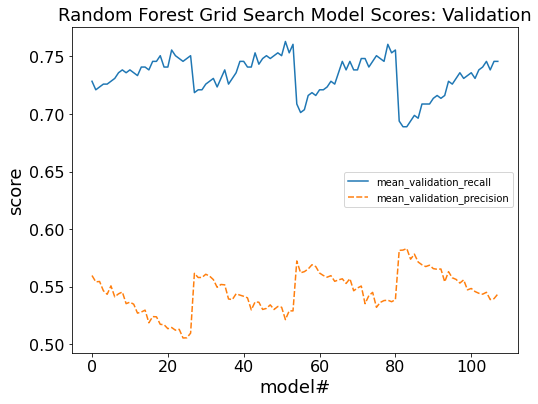

In [100]:
plt.figure(figsize=(8,6))
# sns.lineplot(data =rf_grid_fine_scores_validation)
sns.lineplot(data =rf_grid_fine_scores[['mean_validation_recall','mean_validation_precision']])
plt.legend( loc=5) #bbox_to_anchor=(1.05,1)
plt.xlabel('model#', fontsize=18)
plt.ylabel('score', fontsize=18)
plt.title('Random Forest Grid Search Model Scores: Validation', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('../output/rf_grid_fine_scores_validation_2score_dropDurationMedianIP.png', bbox_inches='tight')

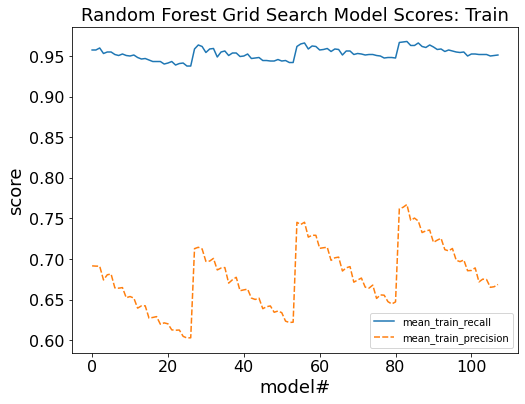

In [104]:
plt.figure(figsize=(8,6))
# sns.lineplot(data =rf_grid_scores_train)
sns.lineplot(data =rf_grid_fine_scores[['mean_train_recall','mean_train_precision']])
plt.legend(loc=4) #bbox_to_anchor=(1.05,1)
plt.xlabel('model#', fontsize=18)
plt.ylabel('score', fontsize=18)
plt.title('Random Forest Grid Search Model Scores: Train', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('../output/rf_grid_fine_scores_train_2score_dropDurationMedianIP.png', bbox_inches='tight')

In [109]:
# choose best model based on a score: favor sensitivity
# want to maximize false positive over all positives (low precision), minimize false negative (high recall)
best_row = rf_grid_fine_scores.mean_validation_recall.idxmax()
worst_row = rf_grid_fine_scores.mean_validation_recall.idxmin()
print('best RF row number', best_row)
print('worst RF row number', worst_row)
print('best RF fine', rf_grid_fine_scores.params[best_row])
display(rf_grid_fine_scores[rf_grid_fine_scores.columns[rf_grid_fine_scores.columns.str.contains('mean_validation')]].iloc[[best_row,]])
display(rf_grid_fine_scores[rf_grid_fine_scores.columns[rf_grid_fine_scores.columns.str.contains('mean_train')]].iloc[[best_row,]])

rf_fine_mf = rf_grid_fine_scores.params[best_row]['max_features']
rf_fine_mss = rf_grid_fine_scores.params[best_row]['min_samples_split']
rf_fine_ne = rf_grid_fine_scores.params[best_row]['n_estimators']
print(rf_fine_mf, rf_fine_mss, rf_fine_ne)

best RF row number 51
worst RF row number 82
best RF fine {'max_features': 2, 'min_samples_split': 24, 'n_estimators': 200}


,mean_validation_recall,mean_validation_f1,mean_validation_precision,mean_validation_accuracy,mean_validation_specificity,mean_validation_roc_auc_score
51,0.762963,0.619349,0.521384,0.912201,0.927608,0.845286


,mean_train_recall,mean_train_f1,mean_train_precision,mean_train_accuracy,mean_train_specificity,mean_train_roc_auc_score
51,0.944444,0.751137,0.623532,0.941428,0.941117,0.942781


2 24 200


In [117]:
# best RF model fit: fine grid search
rf_best_fine = RandomForestClassifier(oob_score=True, class_weight='balanced', 
                                        max_features=rf_fine_mf, 
                                        min_samples_split=rf_fine_mss, 
                                        n_estimators=rf_fine_ne, )
rf_best_fine.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=24,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [127]:
rf_best_fine.score(xtrain,ytrain)

0.9392329020332717

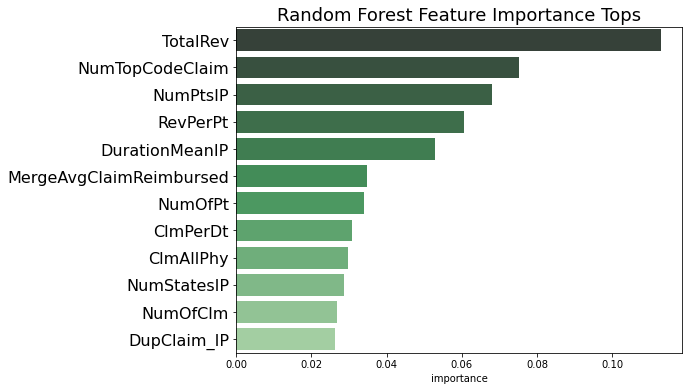

In [119]:
rf_feature_imp_fine = pd.DataFrame(data = rf_best_fine.feature_importances_, index=xtrain.columns, 
                                   columns=['importance']).sort_values(by = 'importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(y = rf_feature_imp_fine.index[:12], x = 'importance', 
            data = rf_feature_imp_fine[:12],palette=sns.color_palette('Greens_d', n_colors=12))
plt.title('Random Forest Feature Importance Tops', fontsize=18)
plt.yticks(fontsize = 16)

# rf_feature_imp_fine.to_csv('../output/rf_grid_fine_features_importance_dropDurationMedianIP.csv')
plt.savefig('../output/rf_fine_feature_importance_green_dropDurationMedianIP.png', bbox_inches='tight')

,0,1
0,3684,239
1,24,381


              precision    recall  f1-score   support

           0       0.99      0.94      0.97      3923
           1       0.61      0.94      0.74       405

    accuracy                           0.94      4328
   macro avg       0.80      0.94      0.85      4328
weighted avg       0.96      0.94      0.94      4328



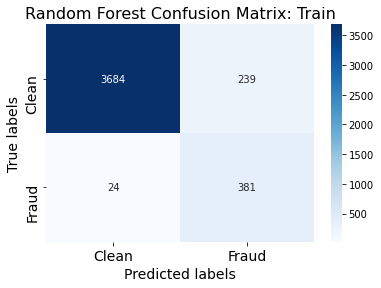

In [123]:
# confusion matrix
ypred = rf_best_fine.predict(xtrain)

labels = np.unique(ytrain)
cm = confusion_matrix(ytrain, ypred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
display(cm_df)

print(classification_report(ytrain.array, ypred))

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt='g')
ax.set_xlabel('Predicted labels', fontsize=14)
ax.set_ylabel('True labels', fontsize=14)
ax.set_title('Random Forest Confusion Matrix: Train', fontsize=16)
ax.xaxis.set_ticklabels(['Clean','Fraud', ], fontsize=14)
ax.yaxis.set_ticklabels(['Clean','Fraud',], fontsize=14)
plt.savefig('../output/rf_fine_train_cm_heatmap_dropDurationMedianIP.png')

,0,1
0,912,69
1,30,71


              precision    recall  f1-score   support

           0       0.97      0.93      0.95       981
           1       0.51      0.70      0.59       101

    accuracy                           0.91      1082
   macro avg       0.74      0.82      0.77      1082
weighted avg       0.93      0.91      0.91      1082



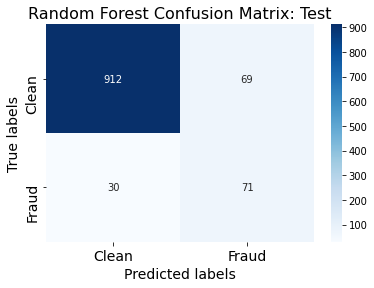

In [122]:
# confusion matrix
ypred_test = rf_best_fine.predict(xtest)

labels = np.unique(ytest)
cm = confusion_matrix(ytest, ypred_test, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
display(cm_df)

print(classification_report(ytest.array, ypred_test))

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt='g')
ax.set_xlabel('Predicted labels', fontsize=14)
ax.set_ylabel('True labels', fontsize=14)
ax.set_title('Random Forest Confusion Matrix: Test', fontsize=16)
ax.xaxis.set_ticklabels(['Clean','Fraud', ], fontsize=14)
ax.yaxis.set_ticklabels(['Clean','Fraud',], fontsize=14)
plt.savefig('../output/rf_fine_test_cm_heatmap_dropDurationMedianIP.png')

## EDA feature

In [1074]:
df_dum.columns

Index(['PotentialFraud', 'DurationMedianIP', 'DurationMeanIP', 'DurationMedianOP', 'DurationMeanOP', 'ChronCondsMedian', 'ChronCondsMean', 'ChronConsMode', 'PtAgeMedian', 'PtAgeMean', 'NumPtsIP', 'NumPtsOP', 'NumStatesIP', 'NumStatesOP', 'SharePhysician', 'MergeAvgClaimReimbursed', 'NumTopCodeClaim', 'DupClaimNum_IP', 'DupClaimRatio_IP', 'DupClaim_IP', 'DupClaimStatesNum_IP', 'DupClaimMultiState_IP', 'DupClaimProviderNum_IP', 'DupClaimMultiProvider_IP', 'DupClaimStartDtNum_IP', 'DupClaimMultiStartDt_IP', 'DupClaimNum_OP', 'DupClaimRatio_OP', 'DupClaim_OP', 'DupClaimStatesNum_OP', 'DupClaimMultiState_OP', 'DupClaimProviderNum_OP', 'DupClaimMultiProvider_OP', 'DupClaimStartDtNum_OP', 'DupClaimMultiStartDt_OP', 'AvgDuration', 'NumOfPt', 'NumOfClm', 'ClmPerPt', 'TotalRev', 'RevPerPt', 'ClmNoPhy', 'ClmAllPhy', 'ClmNoProc', 'ClmPerDt', 'Serves__IP', 'Serves__OP'], dtype='object')

Text(0.5, 1.0, 'DupClaimFlag')

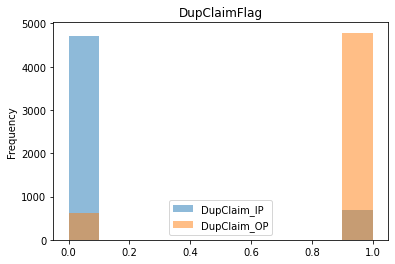

In [128]:
df_dum.DupClaim_IP.plot.hist(alpha = 0.5)
df_dum.DupClaim_OP.plot.hist(alpha = 0.5)
plt.legend()
plt.title('DupClaimFlag')
# plt.savefig('../output/flag_dupclaimratio.png')

In [1115]:
from statsmodels.graphics.mosaicplot import mosaic
# mosaic plot
df_dum[['DupClaim_IP', 'DupClaim_OP']].head()
a = pd.DataFrame(df_dum.DupClaim_IP.value_counts()).reset_index().rename(columns={'index':"PotentialFraud"})
b = pd.DataFrame(df_dum.DupClaim_OP.value_counts()).reset_index().rename(columns={'index':"PotentialFraud"})
display(a)
display(b)
c = a.merge(b, how='inner', on='PotentialFraud')
c['PotentialFraud'] = np.where(c['PotentialFraud'] == 0, 'No', 'Yes')
c.set_index('PotentialFraud', inplace = True)
display(c)
d = c.to_dict()

,PotentialFraud,DupClaim_IP
0,0,4715
1,1,695


,PotentialFraud,DupClaim_OP
0,1,4786
1,0,624


,DupClaim_IP,DupClaim_OP
PotentialFraud,,
No,4715,624
Yes,695,4786


{'DupClaim_IP': {'No': 4715, 'Yes': 695}, 'DupClaim_OP': {'No': 624, 'Yes': 4786}}


(<Figure size 432x288 with 3 Axes>,
 OrderedDict([(('4715', '624'),
               (0.0, 0.0, 0.49751243781094534, 0.9966777408637874)),
              (('4715', '4786'), (0.0, 1.0, 0.49751243781094534, 0.0)),
              (('695', '624'),
               (0.5024875621890548, 0.0, 0.49751243781094534, 0.0)),
              (('695', '4786'),
               (0.5024875621890548,
                0.0033222591362126247,
                0.49751243781094534,
                0.9966777408637874))]))

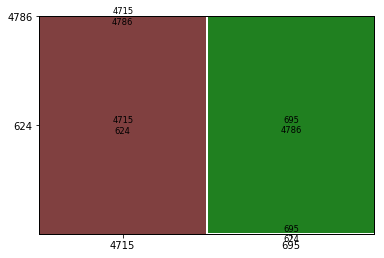

In [1120]:
print(d)
DupClaim_IP = [4715, 695]
DupClaim_OP = [624,4786]
data = pd.DataFrame({'IP': DupClaim_IP, 'OP': DupClaim_OP})
mosaic(data, ['IP', 'OP'])

(<Figure size 432x288 with 1 Axes>,
 OrderedDict([(('No',), (0.0, 0.0, 0.8629051444885709, 1.0)),
              (('Yes',), (0.8728061345875808, 0.0, 0.1271938654124192, 1.0))]))

<Figure size 72x432 with 0 Axes>

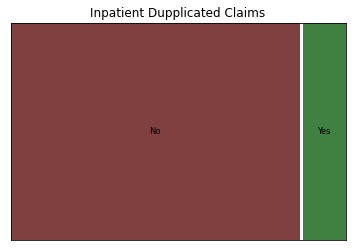

In [1118]:
plt.figure(figsize=(1,6))
mosaic(d['DupClaim_IP'], title = 'Inpatient Dupplicated Claims', gap=0.01, axes_label = False)
# mosaic(d['DupClaim_OP'], title = 'Outpatient Dupplicated Claims', gap=0.01, axes_label = False)

### K means clustering